In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import copy
from sklearn.preprocessing import LabelEncoder

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models


In [2]:
class ImagesDataset(Dataset):
    def __init__(self, files, labels, encoder, transforms, mode):
        super().__init__()
        self.files = files
        self.labels = labels
        self.encoder = encoder
        self.transforms = transforms
        self.mode = mode

    def __len__(self):
        return len(self.files)

    def __getitem__(self, index):
        pic = Image.open(self.files[index]).convert('RGB')

        if self.mode == 'train' or self.mode == 'val':
            x = self.transforms(pic)
            label = self.labels[index]
            y = self.encoder.transform([label])[0]
            return x, y
        elif self.mode == 'test':
            x = self.transforms(pic)
            return x, self.files[index]

In [3]:
class EnsembleModel(nn.Module):
    def __init__(self, modelA, modelB, modelC):
        super().__init__()
        self.modelA = modelA
        self.modelB = modelB
        self.modelC = modelC
        self.classifier = nn.Linear(200 * 3, 200)

    def forward(self, x):
        x1 = self.modelA(x)
        x2 = self.modelB(x)
        x3 = self.modelC(x)
        x = torch.cat((x1, x2, x3), dim=1)
        out = self.classifier(x)
        return out


In [4]:
def training(model, model_name, num_epochs, train_dataloader, val_dataloader):

    loss_function = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0003)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.33)

    train_loss_array = []
    train_acc_array = []
    val_loss_array = []
    val_acc_array = []
    lowest_val_loss = np.inf
    best_model = None

    for epoch in tqdm(range(num_epochs)):

        print('Epoch: {} | Learning rate: {}'.format(epoch + 1, scheduler.get_last_lr()))

        for phase in ['train', 'val']:

            epoch_loss = 0
            epoch_correct_items = 0
            epoch_items = 0

            if phase == 'train':
                model.train()
                with torch.enable_grad():
                    for samples, targets in train_dataloader:
                        targets = targets.type(torch.LongTensor)   # casting to long
                        samples = samples.to(DEVICE)
                        targets = targets.to(DEVICE)

                        optimizer.zero_grad()
                        outputs = model(samples)
                        loss = loss_function(outputs, targets)
                        preds = outputs.argmax(dim=1)
                        correct_items = (preds == targets).float().sum()

                        loss.backward()
                        optimizer.step()

                        epoch_loss += loss.item()
                        epoch_correct_items += correct_items.item()
                        epoch_items += len(targets)

                train_loss_array.append(epoch_loss / epoch_items)
                train_acc_array.append(epoch_correct_items / epoch_items)

                scheduler.step()

            elif phase == 'val':
                model.eval()
                with torch.no_grad():
                    for samples, targets in val_dataloader:
                        targets = targets.type(torch.LongTensor)   # casting to long
                        samples = samples.to(DEVICE)
                        targets = targets.to(DEVICE)

                        outputs = model(samples)
                        loss = loss_function(outputs, targets)
                        preds = outputs.argmax(dim=1)
                        correct_items = (preds == targets).float().sum()

                        epoch_loss += loss.item()
                        epoch_correct_items += correct_items.item()
                        epoch_items += len(targets)

                val_loss_array.append(epoch_loss / epoch_items)
                val_acc_array.append(epoch_correct_items / epoch_items)

                if epoch_loss / epoch_items < lowest_val_loss:
                    lowest_val_loss = epoch_loss / epoch_items
                    torch.save(model.state_dict(), '{}_weights.pth'.format(model_name))
                    best_model = copy.deepcopy(model)
                    print("\t| New lowest val loss for {}: {}".format(model_name, lowest_val_loss))

    return best_model, train_loss_array, train_acc_array, val_loss_array, val_acc_array


def visualize_training_results(train_loss_array,
                               val_loss_array,
                               train_acc_array,
                               val_acc_array,
                               num_epochs,
                               model_name,
                               batch_size):

    fig, axs = plt.subplots(1, 2, figsize=(14,4))
    fig.suptitle("{} training | Batch size: {}".format(model_name, batch_size), fontsize = 16)
    axs[0].plot(list(range(1, num_epochs+1)), train_loss_array, label="train_loss")
    axs[0].plot(list(range(1, num_epochs+1)), val_loss_array, label="val_loss")
    axs[0].legend(loc='best')
    axs[0].set(xlabel='epochs', ylabel='loss')
    axs[1].plot(list(range(1, num_epochs+1)), train_acc_array, label="train_acc")
    axs[1].plot(list(range(1, num_epochs+1)), val_acc_array, label="val_acc")
    axs[1].legend(loc='best')
    axs[1].set(xlabel='epochs', ylabel='accuracy')
    plt.show();

In [5]:
if torch.cuda.is_available():
    print('CUDA is available. Working on GPU')
    DEVICE = torch.device('cuda')
else:
    print('CUDA is not available. Working on CPU')
    DEVICE = torch.device('cpu')

CUDA is available. Working on GPU


In [6]:
!wget -O tiny-imagenet-200.zip http://cs231n.stanford.edu/tiny-imagenet-200.zip

--2024-07-07 14:11:59--  http://cs231n.stanford.edu/tiny-imagenet-200.zip
Resolving cs231n.stanford.edu (cs231n.stanford.edu)... 171.64.64.64
Connecting to cs231n.stanford.edu (cs231n.stanford.edu)|171.64.64.64|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://cs231n.stanford.edu/tiny-imagenet-200.zip [following]
--2024-07-07 14:12:00--  https://cs231n.stanford.edu/tiny-imagenet-200.zip
Connecting to cs231n.stanford.edu (cs231n.stanford.edu)|171.64.64.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248100043 (237M) [application/zip]
Saving to: ‘tiny-imagenet-200.zip’

tiny-imagenet-200.z 100%[===================>] 236.61M  8.58MB/s    in 35s     

2024-07-07 14:12:35 (6.79 MB/s) - ‘tiny-imagenet-200.zip’ saved [248100043/248100043]



In [7]:
!unzip tiny-imagenet-200.zip

Streaming output truncated to the last 5000 lines.
  inflating: tiny-imagenet-200/val/images/val_3979.JPEG  
  inflating: tiny-imagenet-200/val/images/val_3963.JPEG  
  inflating: tiny-imagenet-200/val/images/val_7199.JPEG  
  inflating: tiny-imagenet-200/val/images/val_2752.JPEG  
  inflating: tiny-imagenet-200/val/images/val_9687.JPEG  
  inflating: tiny-imagenet-200/val/images/val_9407.JPEG  
  inflating: tiny-imagenet-200/val/images/val_3603.JPEG  
  inflating: tiny-imagenet-200/val/images/val_3412.JPEG  
  inflating: tiny-imagenet-200/val/images/val_6982.JPEG  
  inflating: tiny-imagenet-200/val/images/val_8496.JPEG  
  inflating: tiny-imagenet-200/val/images/val_7332.JPEG  
  inflating: tiny-imagenet-200/val/images/val_9241.JPEG  
  inflating: tiny-imagenet-200/val/images/val_4196.JPEG  
  inflating: tiny-imagenet-200/val/images/val_5980.JPEG  
  inflating: tiny-imagenet-200/val/images/val_6697.JPEG  
  inflating: tiny-imagenet-200/val/images/val_9969.JPEG  
  inflating: tiny-ima

In [8]:
DIR_MAIN = 'tiny-imagenet-200/'
DIR_TRAIN = DIR_MAIN + 'train/'
DIR_VAL = DIR_MAIN + 'val/'
DIR_TEST = DIR_MAIN + 'test/'

# Number of labels - 200
labels = os.listdir(DIR_TRAIN)

# Initialize labels encoder
encoder_labels = LabelEncoder()
encoder_labels.fit(labels)

# Create lists of files and labels for training (100'000 items)
files_train = []
labels_train = []
for label in labels:
    for filename in os.listdir(DIR_TRAIN + label + '/images/'):
        files_train.append(DIR_TRAIN + label + '/images/' + filename)
        labels_train.append(label)

# Create lists of files and labels for validation (10'000 items)
files_val = []
labels_val = []
for filename in os.listdir(DIR_VAL + 'images/'):
    files_val.append(DIR_VAL + 'images/' + filename)

val_df = pd.read_csv(DIR_VAL + 'val_annotations.txt', sep='\t', names=["File", "Label", "X1", "Y1", "X2", "Y2"], usecols=["File", "Label"])
for f in files_val:
    l = val_df.loc[val_df['File'] == f[len(DIR_VAL + 'images/'):]]['Label'].values[0]
    labels_val.append(l)

# List of files for testing (10'000 items)
files_test = []
for filename in os.listdir(DIR_TEST + 'images/'):
    files_test.append(DIR_TEST + 'images/' + filename)
    files_test = sorted(files_test)

print("The first five files from the list of train images:", files_train[:5])
print("\nThe first five labels from the list of train labels:", labels_train[:5])
print("\nThe first five files from the list of validation images:", files_val[:5])
print("\nThe first five labels from the list of validation labels:", labels_val[:5])
print("\nThe first five files from the list of test images:", files_test[:5])

The first five files from the list of train images: ['tiny-imagenet-200/train/n02699494/images/n02699494_468.JPEG', 'tiny-imagenet-200/train/n02699494/images/n02699494_146.JPEG', 'tiny-imagenet-200/train/n02699494/images/n02699494_57.JPEG', 'tiny-imagenet-200/train/n02699494/images/n02699494_190.JPEG', 'tiny-imagenet-200/train/n02699494/images/n02699494_193.JPEG']

The first five labels from the list of train labels: ['n02699494', 'n02699494', 'n02699494', 'n02699494', 'n02699494']

The first five files from the list of validation images: ['tiny-imagenet-200/val/images/val_5793.JPEG', 'tiny-imagenet-200/val/images/val_2228.JPEG', 'tiny-imagenet-200/val/images/val_9801.JPEG', 'tiny-imagenet-200/val/images/val_5010.JPEG', 'tiny-imagenet-200/val/images/val_5440.JPEG']

The first five labels from the list of validation labels: ['n04366367', 'n03637318', 'n07720875', 'n02226429', 'n02094433']

The first five files from the list of test images: ['tiny-imagenet-200/test/images/test_0.JPEG', '

In [9]:
transforms_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.4802, 0.4481, 0.3975], [0.2302, 0.2265, 0.2262]),
    transforms.RandomErasing(p=0.5, scale=(0.06, 0.08), ratio=(1, 3), value=0, inplace=True)
])

transforms_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.4802, 0.4481, 0.3975], [0.2302, 0.2265, 0.2262])
])

In [10]:
train_dataset = ImagesDataset(files=files_train,
                              labels=labels_train,
                              encoder=encoder_labels,
                              transforms=transforms_train,
                              mode='train')

val_dataset = ImagesDataset(files=files_val,
                            labels=labels_val,
                            encoder=encoder_labels,
                            transforms=transforms_val,
                            mode='val')

test_dataset = ImagesDataset(files=files_test,
                             labels=None,
                             encoder=None,
                             transforms=transforms_val,
                             mode='test')


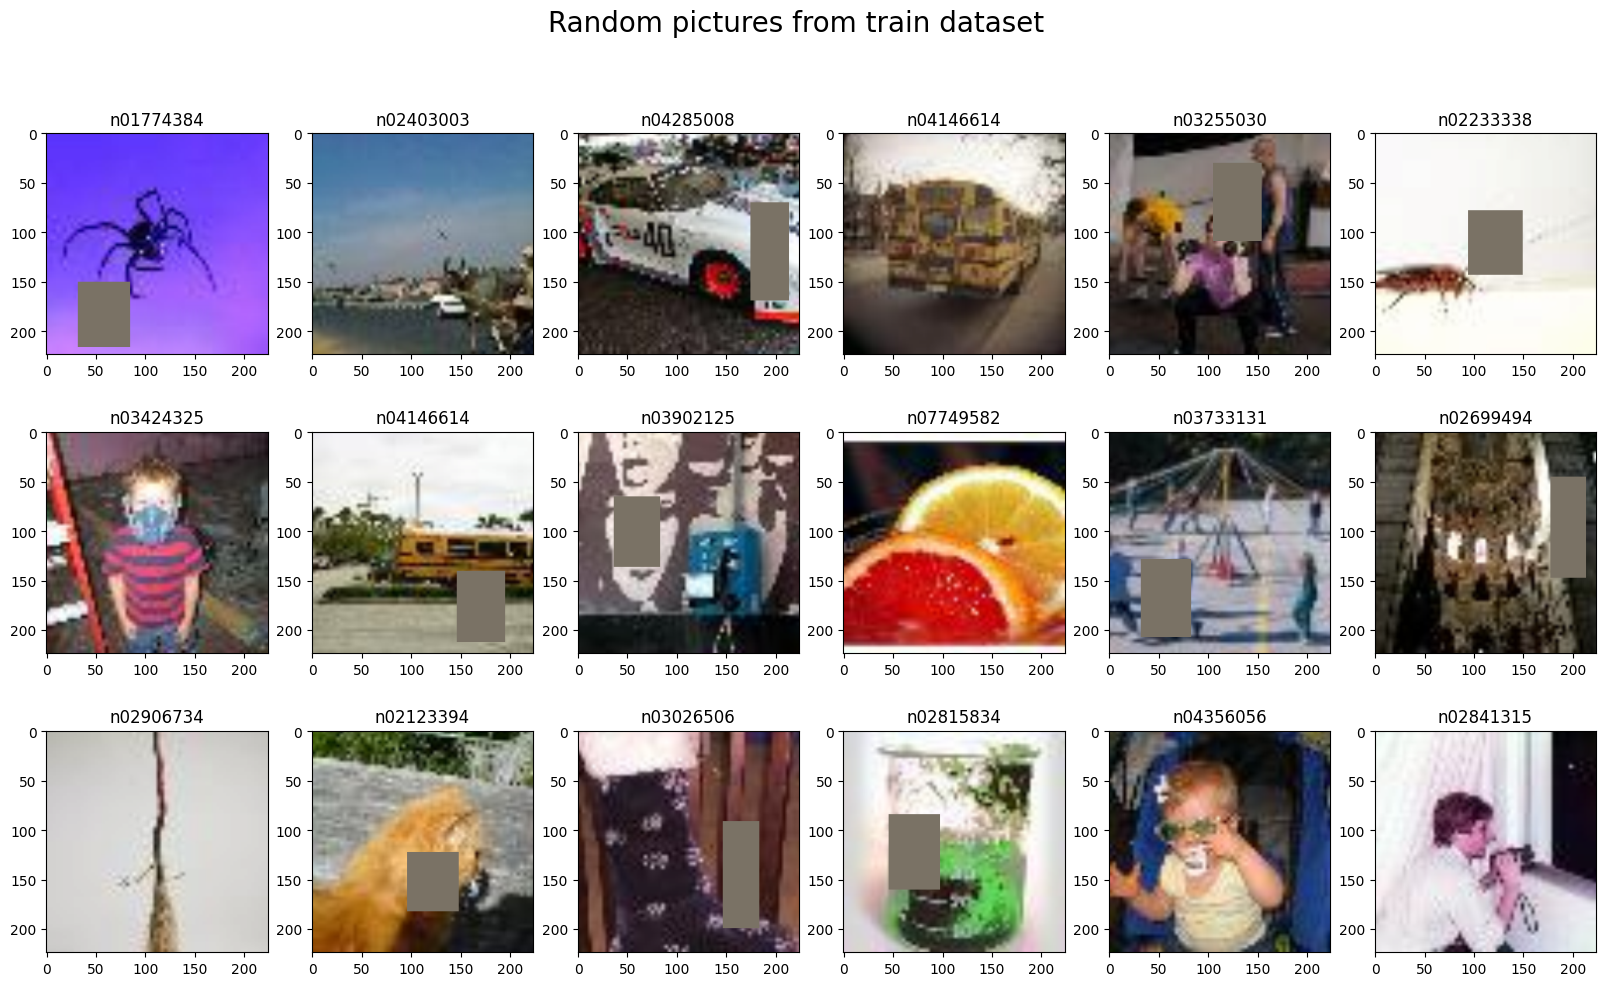

In [11]:
fig, axs = plt.subplots(3, 6, figsize=(20,11))
fig.suptitle('Random pictures from train dataset', fontsize=20)
for ax in axs.flatten():
    n = np.random.randint(len(train_dataset))
    img = train_dataset[n][0]
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.4802, 0.4481, 0.3975])
    std = np.array([0.2302, 0.2265, 0.2262])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    ax.set_title(encoder_labels.inverse_transform([train_dataset[n][1]])[0])
    ax.imshow(img)

In [12]:
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False)
num_epochs = 10

Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.cache/torch/hub/checkpoints/densenet161-8d451a50.pth
100%|██████████| 110M/110M [00:00<00:00, 129MB/s] 
  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | Learning rate: [0.0003]


 10%|█         | 1/10 [05:48<52:20, 348.90s/it]

	| New lowest val loss for DenseNet161: 0.026323778331279756
Epoch: 2 | Learning rate: [0.0003]


 20%|██        | 2/10 [11:34<46:15, 346.91s/it]

	| New lowest val loss for DenseNet161: 0.022056858563423157
Epoch: 3 | Learning rate: [0.0003]


 30%|███       | 3/10 [17:07<39:43, 340.46s/it]

	| New lowest val loss for DenseNet161: 0.02075250322818756
Epoch: 4 | Learning rate: [9.9e-05]


 40%|████      | 4/10 [22:40<33:46, 337.80s/it]

	| New lowest val loss for DenseNet161: 0.020311581480503084
Epoch: 5 | Learning rate: [9.9e-05]


 50%|█████     | 5/10 [28:13<28:00, 336.07s/it]

	| New lowest val loss for DenseNet161: 0.02004790627360344
Epoch: 6 | Learning rate: [9.9e-05]


 60%|██████    | 6/10 [33:47<22:20, 335.18s/it]

	| New lowest val loss for DenseNet161: 0.019840150809288026
Epoch: 7 | Learning rate: [3.267e-05]


 70%|███████   | 7/10 [39:19<16:43, 334.33s/it]

	| New lowest val loss for DenseNet161: 0.019685069280862808
Epoch: 8 | Learning rate: [3.267e-05]


 80%|████████  | 8/10 [44:52<11:07, 333.75s/it]

	| New lowest val loss for DenseNet161: 0.019664489436149596
Epoch: 9 | Learning rate: [3.267e-05]


 90%|█████████ | 9/10 [50:25<05:33, 333.41s/it]

	| New lowest val loss for DenseNet161: 0.01960573650598526
Epoch: 10 | Learning rate: [1.0781099999999999e-05]


100%|██████████| 10/10 [55:58<00:00, 335.86s/it]

	| New lowest val loss for DenseNet161: 0.01952001891732216


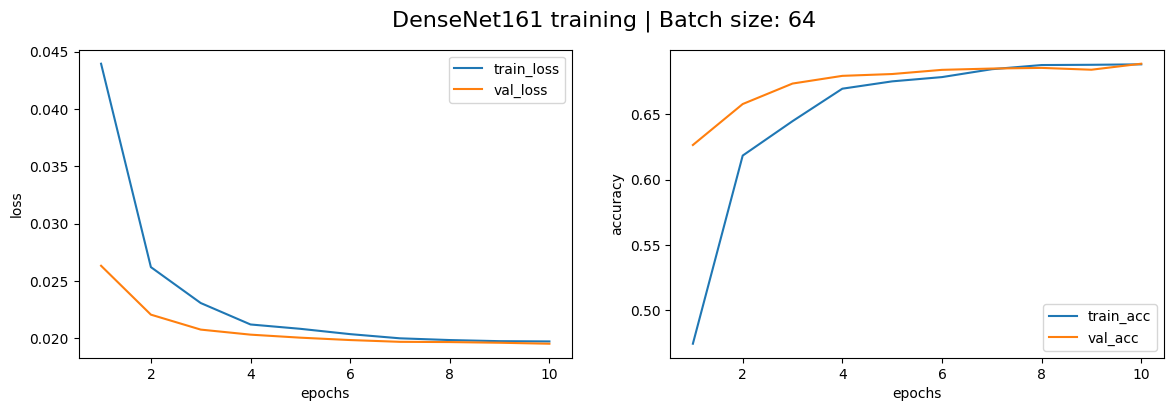


Training results:
	Min val loss 0.0195 was achieved during epoch #10
	Val accuracy during min val loss is 0.6888


In [13]:
model_densenet161 = models.densenet161(pretrained=True)

for param in model_densenet161.parameters():
    param.requires_grad = False
model_densenet161.classifier = torch.nn.Linear(model_densenet161.classifier.in_features, out_features=200)
model_densenet161 = model_densenet161.to(DEVICE)

densenet161_training_results = training(model=model_densenet161,
                                        model_name='DenseNet161',
                                        num_epochs=num_epochs,
                                        train_dataloader=train_dataloader,
                                        val_dataloader=val_dataloader)

model_densenet161, train_loss_array, train_acc_array, val_loss_array, val_acc_array = densenet161_training_results

min_loss = min(val_loss_array)
min_loss_epoch = val_loss_array.index(min_loss)
min_loss_accuracy = val_acc_array[min_loss_epoch]

visualize_training_results(train_loss_array,
                           val_loss_array,
                           train_acc_array,
                           val_acc_array,
                           num_epochs,
                           model_name="DenseNet161",
                           batch_size=64)

print("\nTraining results:")
print("\tMin val loss {:.4f} was achieved during epoch #{}".format(min_loss, min_loss_epoch + 1))
print("\tVal accuracy during min val loss is {:.4f}".format(min_loss_accuracy))

Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth
100%|██████████| 230M/230M [00:01<00:00, 211MB/s]
  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | Learning rate: [0.0003]


 10%|█         | 1/10 [04:58<44:45, 298.42s/it]

	| New lowest val loss for ResNet152: 0.02457300808429718
Epoch: 2 | Learning rate: [0.0003]


 20%|██        | 2/10 [09:58<39:55, 299.38s/it]

	| New lowest val loss for ResNet152: 0.022142039197683334
Epoch: 3 | Learning rate: [0.0003]


 30%|███       | 3/10 [14:57<34:55, 299.34s/it]

	| New lowest val loss for ResNet152: 0.021126646906137466
Epoch: 4 | Learning rate: [9.9e-05]


 40%|████      | 4/10 [19:57<29:57, 299.55s/it]

	| New lowest val loss for ResNet152: 0.02050503282546997
Epoch: 5 | Learning rate: [9.9e-05]


 50%|█████     | 5/10 [24:56<24:57, 299.42s/it]

	| New lowest val loss for ResNet152: 0.020338785362243653
Epoch: 6 | Learning rate: [9.9e-05]


 60%|██████    | 6/10 [29:54<19:55, 298.85s/it]

	| New lowest val loss for ResNet152: 0.020197895503044128
Epoch: 7 | Learning rate: [3.267e-05]


 70%|███████   | 7/10 [34:54<14:57, 299.29s/it]

	| New lowest val loss for ResNet152: 0.02018944029211998
Epoch: 8 | Learning rate: [3.267e-05]


 80%|████████  | 8/10 [39:54<09:58, 299.42s/it]

	| New lowest val loss for ResNet152: 0.020121209931373597
Epoch: 9 | Learning rate: [3.267e-05]


 90%|█████████ | 9/10 [44:54<04:59, 299.65s/it]

	| New lowest val loss for ResNet152: 0.020070246690511703
Epoch: 10 | Learning rate: [1.0781099999999999e-05]


100%|██████████| 10/10 [49:55<00:00, 299.51s/it]

	| New lowest val loss for ResNet152: 0.01998005190491676


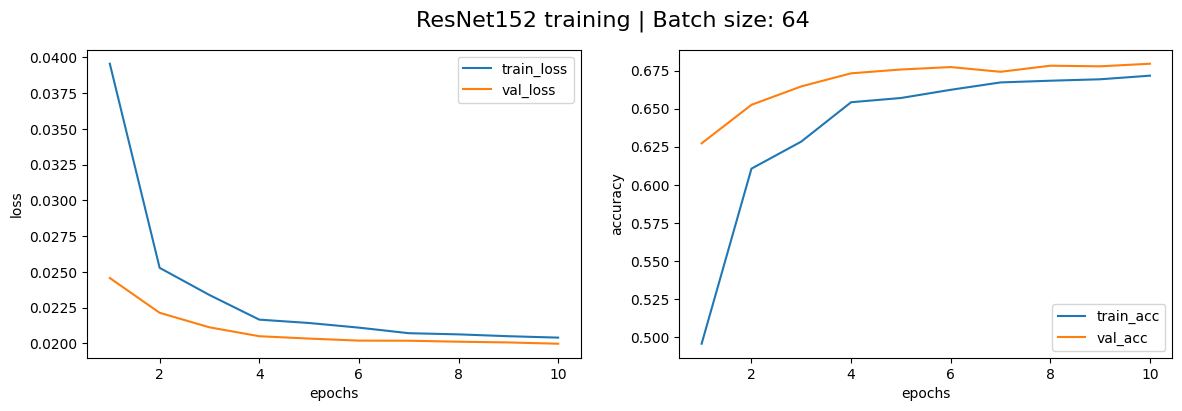


Training results:
	Min val loss 0.0200 was achieved during epoch #10
	Val accuracy during min val loss is 0.6795


In [14]:
model_resnet152 = models.resnet152(pretrained=True)
for param in model_resnet152.parameters():
    param.requires_grad = False
model_resnet152.fc = torch.nn.Linear(model_resnet152.fc.in_features, 200)
model_resnet152 = model_resnet152.to(DEVICE)

resnet152_training_results = training(model=model_resnet152,
                                      model_name='ResNet152',
                                      num_epochs=num_epochs,
                                      train_dataloader=train_dataloader,
                                      val_dataloader=val_dataloader)

model_resnet152, train_loss_array, train_acc_array, val_loss_array, val_acc_array = resnet152_training_results

min_loss = min(val_loss_array)
min_loss_epoch = val_loss_array.index(min_loss)
min_loss_accuracy = val_acc_array[min_loss_epoch]

visualize_training_results(train_loss_array,
                           val_loss_array,
                           train_acc_array,
                           val_acc_array,
                           num_epochs,
                           model_name="ResNet152",
                           batch_size=64)
print("\nTraining results:")
print("\tMin val loss {:.4f} was achieved during epoch #{}".format(min_loss, min_loss_epoch + 1))
print("\tVal accuracy during min val loss is {:.4f}".format(min_loss_accuracy))

Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /root/.cache/torch/hub/checkpoints/vgg19_bn-c79401a0.pth
100%|██████████| 548M/548M [00:03<00:00, 154MB/s]
  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | Learning rate: [0.0003]


 10%|█         | 1/10 [04:54<44:08, 294.26s/it]

	| New lowest val loss for VGG19_bn: 0.030009248769283296
Epoch: 2 | Learning rate: [0.0003]


 20%|██        | 2/10 [09:51<39:27, 295.98s/it]

	| New lowest val loss for VGG19_bn: 0.02866222952604294
Epoch: 3 | Learning rate: [0.0003]


 30%|███       | 3/10 [14:48<34:35, 296.55s/it]

	| New lowest val loss for VGG19_bn: 0.028256314742565156
Epoch: 4 | Learning rate: [9.9e-05]


 40%|████      | 4/10 [19:44<29:36, 296.17s/it]

	| New lowest val loss for VGG19_bn: 0.02760469037294388
Epoch: 5 | Learning rate: [9.9e-05]


 50%|█████     | 5/10 [24:38<24:37, 295.54s/it]

Epoch: 6 | Learning rate: [9.9e-05]


 60%|██████    | 6/10 [29:35<19:43, 295.82s/it]

	| New lowest val loss for VGG19_bn: 0.027383895003795625
Epoch: 7 | Learning rate: [3.267e-05]


 70%|███████   | 7/10 [34:32<14:48, 296.26s/it]

	| New lowest val loss for VGG19_bn: 0.027202048122882842
Epoch: 8 | Learning rate: [3.267e-05]


 80%|████████  | 8/10 [39:27<09:52, 296.01s/it]

	| New lowest val loss for VGG19_bn: 0.027162122559547423
Epoch: 9 | Learning rate: [3.267e-05]


 90%|█████████ | 9/10 [44:22<04:55, 295.78s/it]

	| New lowest val loss for VGG19_bn: 0.027029092049598694
Epoch: 10 | Learning rate: [1.0781099999999999e-05]


100%|██████████| 10/10 [49:19<00:00, 295.91s/it]


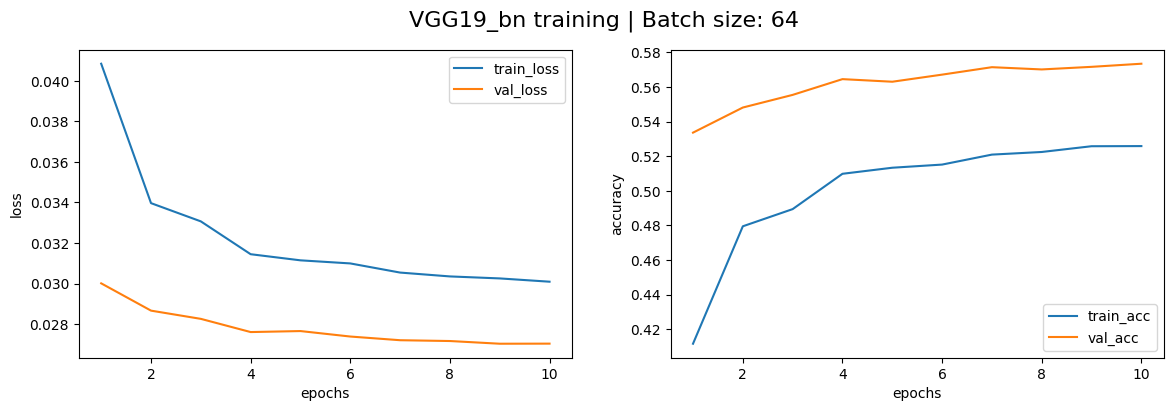


Training results:
	Min val loss 0.0270 was achieved during epoch #9
	Val accuracy during min val loss is 0.5716


In [15]:
model_vgg19_bn = models.vgg19_bn(pretrained=True)
for param in model_vgg19_bn.parameters():
    param.requires_grad = False
model_vgg19_bn.classifier[6] = torch.nn.Linear(in_features=model_vgg19_bn.classifier[6].in_features, out_features=200)
model_vgg19_bn = model_vgg19_bn.to(DEVICE)

vgg19_bn_training_results = training(model=model_vgg19_bn,
                                     model_name='VGG19_bn',
                                     num_epochs=num_epochs,
                                     train_dataloader=train_dataloader,
                                     val_dataloader=val_dataloader)

model_vgg19_bn, train_loss_array, train_acc_array, val_loss_array, val_acc_array = vgg19_bn_training_results

min_loss = min(val_loss_array)
min_loss_epoch = val_loss_array.index(min_loss)
min_loss_accuracy = val_acc_array[min_loss_epoch]

visualize_training_results(train_loss_array,
                           val_loss_array,
                           train_acc_array,
                           val_acc_array,
                           num_epochs,
                           model_name="VGG19_bn",
                           batch_size=64)
print("\nTraining results:")
print("\tMin val loss {:.4f} was achieved during epoch #{}".format(min_loss, min_loss_epoch + 1))
print("\tVal accuracy during min val loss is {:.4f}".format(min_loss_accuracy))

In [16]:
ensemble_model = EnsembleModel(model_densenet161, model_resnet152, model_vgg19_bn)

for param in ensemble_model.parameters():
    param.requires_grad = False

for param in ensemble_model.classifier.parameters():
    param.requires_grad = True

ensemble_model = ensemble_model.to(DEVICE)

In [17]:
ensemble_training_results = training(model=ensemble_model,
                                     model_name='Ensemble',
                                     num_epochs=5,
                                     train_dataloader=train_dataloader,
                                     val_dataloader=val_dataloader)

ensemble_model, train_loss_array, train_acc_array, val_loss_array, val_acc_array = ensemble_training_results

min_loss = min(val_loss_array)
min_loss_iteration = val_loss_array.index(min_loss)
min_loss_accuracy = val_acc_array[min_loss_iteration]


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | Learning rate: [0.0003]


 20%|██        | 1/5 [08:07<32:28, 487.11s/it]

	| New lowest val loss for Ensemble: 0.030818362152576446
Epoch: 2 | Learning rate: [0.0003]


 40%|████      | 2/5 [16:15<24:24, 488.10s/it]

	| New lowest val loss for Ensemble: 0.02794027454853058
Epoch: 3 | Learning rate: [0.0003]


 60%|██████    | 3/5 [24:24<16:16, 488.39s/it]

	| New lowest val loss for Ensemble: 0.02508539011478424
Epoch: 4 | Learning rate: [9.9e-05]


 80%|████████  | 4/5 [32:36<08:09, 489.58s/it]

	| New lowest val loss for Ensemble: 0.020643570363521577
Epoch: 5 | Learning rate: [9.9e-05]


100%|██████████| 5/5 [40:46<00:00, 489.23s/it]

	| New lowest val loss for Ensemble: 0.020591318947076796


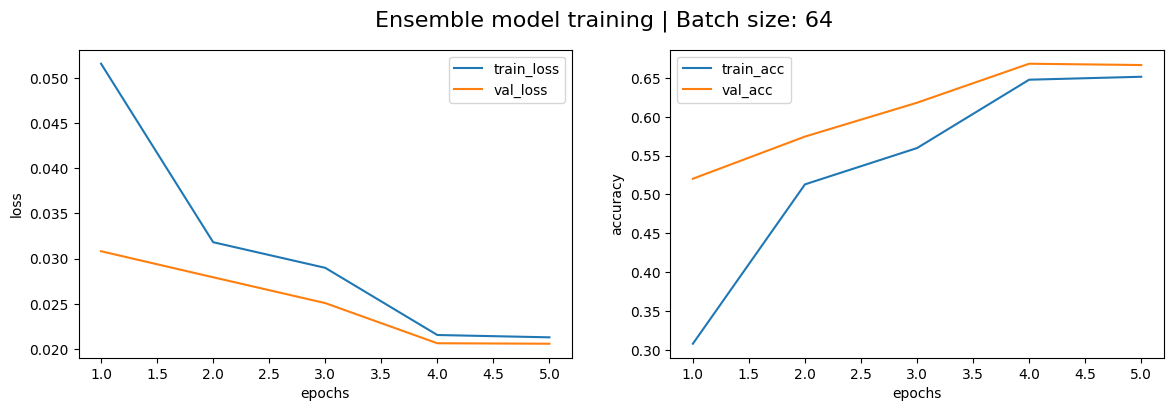


Training results:
	Min val loss 0.0206 was achieved during iteration #5
	Val accuracy during min val loss is 0.6666


In [18]:
visualize_training_results(train_loss_array,
                           val_loss_array,
                           train_acc_array,
                           val_acc_array,
                           num_epochs=5,
                           model_name="Ensemble model",
                           batch_size=64)
print("\nTraining results:")
print("\tMin val loss {:.4f} was achieved during iteration #{}".format(min_loss, min_loss_iteration + 1))
print("\tVal accuracy during min val loss is {:.4f}".format(min_loss_accuracy))

In [19]:
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

all_preds = []
all_files = []

ensemble_model.eval()
with torch.no_grad():
    for samples, f_names in tqdm(test_dataloader):
        samples = samples.to(DEVICE)
        outputs = ensemble_model(samples)
        preds = outputs.argmax(dim=1)
        all_preds.extend(preds.tolist())
        all_files.extend(f_names)

all_filenames = [f_name[30:] for f_name in all_files]
all_preds_decoded = encoder_labels.inverse_transform(all_preds)

submission_ensemble_df = pd.DataFrame(list(zip(all_filenames, all_preds_decoded)), columns =['File', 'Prediction'])
submission_ensemble_df.to_csv('test_predictions_ensemble.csv', header=False, index=False)
submission_ensemble_df.head(10)

100%|██████████| 157/157 [00:38<00:00,  4.10it/s]


,File,Prediction
0,test_0.JPEG,n02948072
1,test_1.JPEG,n07871810
2,test_10.JPEG,n07583066
3,test_100.JPEG,n04376876
4,test_1000.JPEG,n02099601
5,test_1001.JPEG,n03617480
6,test_1002.JPEG,n03637318
7,test_1003.JPEG,n01910747
8,test_1004.JPEG,n03404251
9,test_1005.JPEG,n03388043
